# Example Jupyter Notebook

In this Jupyter Notebook, we demonstrate the following operations using `sarxarray`:

- Load an SLC stack in binary format into a `xarray.Dataset` object;
- Append lat and lon coordinates;
- Create an MRM of a subset of the SLC stack;
- Apply point selection to a subset of the SLC stack;
- Export the selection results in Zarr format

### Data used for this Notebook

- [Sentinel-1 interferogram stack over Amsterdam](https://figshare.com/ndownloader/files/41012180)

### Setup environment
For the python environment setup, we assume you already installed SARXarray following the installation guide.

Some extra python dependencies are required to execute this notebook. You can install the extra python dependencies by:
```sh
pip install sarxarray[demo]
```

After installation, execute the notebook in a JupyterLab session, which can be started by running `jupyterlab` command in your command line:

```bash
jupyter-lab
```

A new tab will be opened in your default browser to execute this notebook.

### Load a interferogram stack

In [1]:
import numpy as np
from pathlib import Path
import sarxarray

We will load a interferogram stack, which has been corregistered and saved as binary files. In this example we will demo 3 interferograms with a `(azimuth, range)` coverage of `(9914, 41174)`. We assume the shape and data type is known.

In [2]:
# Path to the interferogram dataset
path = Path('../../data/nl_amsterdam_s1_asc_t088')

# Make a list of SLCs to read
f_slc = 'cint_srd.raw'
list_slcs = [p for p in path.rglob('*_cint_srd.raw')]
list_slcs.sort()

# Metadata of the stack, assume known.
shape=(2000, 4000)

# Define reading chunks
reading_chunks = (500,500)

list_slcs

[PosixPath('../../data/nl_amsterdam_s1_asc_t088/20180920_cint_srd.raw'),
 PosixPath('../../data/nl_amsterdam_s1_asc_t088/20180926_cint_srd.raw'),
 PosixPath('../../data/nl_amsterdam_s1_asc_t088/20181002_cint_srd.raw'),
 PosixPath('../../data/nl_amsterdam_s1_asc_t088/20181008_cint_srd.raw'),
 PosixPath('../../data/nl_amsterdam_s1_asc_t088/20181014_cint_srd.raw'),
 PosixPath('../../data/nl_amsterdam_s1_asc_t088/20181020_cint_srd.raw'),
 PosixPath('../../data/nl_amsterdam_s1_asc_t088/20181026_cint_srd.raw'),
 PosixPath('../../data/nl_amsterdam_s1_asc_t088/20181101_cint_srd.raw'),
 PosixPath('../../data/nl_amsterdam_s1_asc_t088/20181107_cint_srd.raw'),
 PosixPath('../../data/nl_amsterdam_s1_asc_t088/20181113_cint_srd.raw')]

Now we perform a lazy loading of the stack

In [3]:
# Load complex data
stack = sarxarray.from_binary(list_slcs, shape, dtype=np.complex64, chunks=reading_chunks)
stack

<xarray.Dataset>
Dimensions:    (azimuth: 2000, range: 4000, time: 10)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range      (range) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>

The data variable of the stack will be a `Dask.array`. For example we can take a look of `complex`, which is the complex value of the interferograms:

In [4]:
stack.complex

<xarray.DataArray 'complex' (azimuth: 2000, range: 4000, time: 10)>
dask.array<concatenate, shape=(2000, 4000, 10), dtype=complex64, chunksize=(500, 500, 1), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range    (range) int64 0 1 2 3 4 5 6 ... 3993 3994 3995 3996 3997 3998 3999
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9

### Append georeferenced coordinates as new data fields

The `sarxarray` is implemented as an extension of `Xarray.Dataset`, which means we can modify the `stack` variable as a normal `Dataset` objet. For example, we can load in the georeference coordinates (lattitude and longitude) also with `from_binary`, and attach them to `stack`.

In [5]:
# Geo-referenced coordinates
f_lat = [path / 'lat.raw']
f_lon = [path / 'lon.raw']

In [6]:
# Load coordinates
lat = sarxarray.from_binary(f_lat, shape, vlabel="lat", dtype=np.float32, chunks=reading_chunks)
lon = sarxarray.from_binary(f_lon, shape, vlabel="lon", dtype=np.float32, chunks=reading_chunks)
stack = stack.assign_coords(lat = (("azimuth", "range"), lat.squeeze().lat.data), lon = (("azimuth", "range"), lon.squeeze().lon.data))
stack

<xarray.Dataset>
Dimensions:    (azimuth: 2000, range: 4000, time: 10)
Coordinates:
  * azimuth    (azimuth) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * range      (range) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    lat        (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lon        (azimuth, range) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(500, 500, 1), meta=np.ndarray>

### Multi-Looking

In [7]:
stack_multilook = stack.slcstack.multi_look((1,2))
stack_multilook

<xarray.Dataset>
Dimensions:    (azimuth: 2000, range: 2000, time: 10)
Coordinates:
  * azimuth    (azimuth) float64 0.0 1.0 2.0 ... 1.997e+03 1.998e+03 1.999e+03
  * range      (range) float64 0.5 2.5 4.5 6.5 ... 3.994e+03 3.996e+03 3.998e+03
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    lat        (azimuth, range) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    lon        (azimuth, range) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Data variables:
    complex    (azimuth, range, time) complex64 dask.array<chunksize=(1000, 1000, 10), meta=np.ndarray>
    amplitude  (azimuth, range, time) float32 dask.array<chunksize=(1000, 1000, 10), meta=np.ndarray>
    phase      (azimuth, range, time) float32 dask.array<chunksize=(1000, 1000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

### Create MRM of a subset
We will compute a Mean Reflection Map (MRM) using a subset of the stack.

In [8]:
mrm = stack_multilook.slcstack.mrm()
mrm

<xarray.DataArray 'amplitude' (azimuth: 2000, range: 2000)>
dask.array<mean_agg-aggregate, shape=(2000, 2000), dtype=float32, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * azimuth  (azimuth) float64 0.0 1.0 2.0 3.0 ... 1.997e+03 1.998e+03 1.999e+03
  * range    (range) float64 0.5 2.5 4.5 6.5 ... 3.994e+03 3.996e+03 3.998e+03
    lat      (azimuth, range) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    lon      (azimuth, range) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>

In [9]:
# Compute mrm
mrm = mrm.compute()

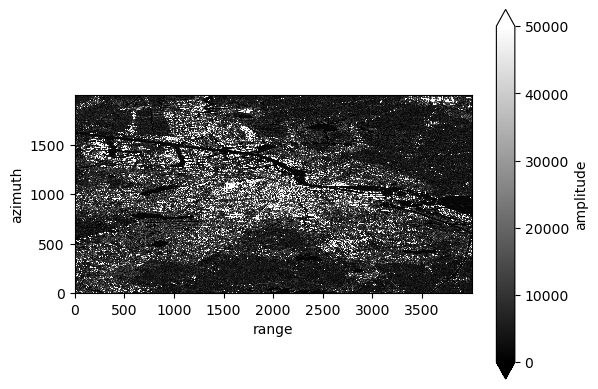

In [10]:
# Visualize
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.imshow(mrm)
im = mrm.plot(ax=ax, robust=True, cmap='gray')
im.set_clim([0, 50000])

### Export to a Space Time Matrix
To prepare the data for PSI processing, we can select temporal consistant pixels, and transform them into a Space-Time Matrix. This can be done using the `point_selection` function

In [11]:
# Select a subset
stack_subset = stack.sel(azimuth=range(100,1800), range=range(1000,3000))

# Perform point selection
stm = stack_subset.slcstack.point_selection(threshold=0.20, method="amplitude_dispersion")
stm

<xarray.Dataset>
Dimensions:    (time: 10, points: 78582)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
    lat        (points) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    azimuth    (points) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
Dimensions without coordinates: points
Data variables:
    complex    (points, time) complex64 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    amplitude  (points, time) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

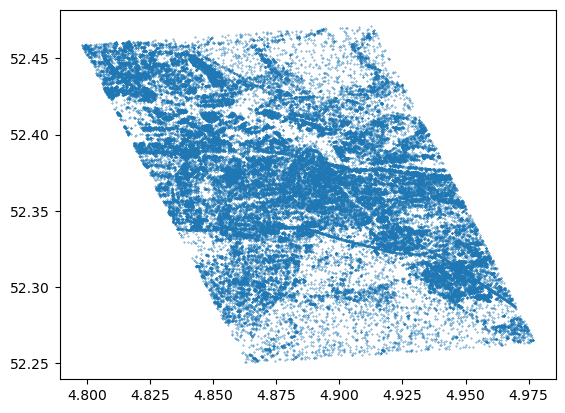

In [12]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
plt.scatter(stm.lon.data, stm.lat.data, s=0.1)

The selected points can be saved to a `Zarr` storage

In [13]:
# Export to Zarr
stm.to_zarr("stm.zarr", mode="w")

And can be read by `xr.open_zarr`

In [14]:
# Load exported STM in Zarr
import xarray as xr
stm_read = xr.open_zarr("stm.zarr")
stm_read

<xarray.Dataset>
Dimensions:    (points: 78582, time: 10)
Coordinates:
    azimuth    (points) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
    lat        (points) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    lon        (points) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
    range      (points) int64 dask.array<chunksize=(1000,), meta=np.ndarray>
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: points
Data variables:
    amplitude  (points, time) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    complex    (points, time) complex64 dask.array<chunksize=(1000, 10), meta=np.ndarray>
    phase      (points, time) float32 dask.array<chunksize=(1000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean